# Wine quality - Whitebox model

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc, average_precision_score, f1_score, precision_score, recall_score
from sklearn.tree import export_text
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/wine-quality-dataset/WineQT.csv
/kaggle/input/wine-quality-dataset-red-white/winequality-white.csv
/kaggle/input/wine-quality-dataset-red-white/winequality-red.csv


I decided to frame the problem as a binary classification task: predicting whether a wine sample is of good or poor quality. The original dataset contains quality ratings ranging from 3 to 9, with the majority of wines rated 5 or 6. Wines with a score of 7 or higher were defined as good quality, while those rated below 7 were considered poor quality.

The red and white wine datasets were combined into a single dataset to increase the sample size and enable the model to learn from both wine types. A new binary feature was added to indicate wine type, where 0 represents red wine and 1 represents white wine.

Duplicate entries were removed prior to training to ensure that the model would not be influenced by repeated samples.

In [ ]:
# Load red wine data and label it as red (0)
df_red = pd.read_csv("/kaggle/input/wine-quality-dataset-red-white/winequality-red.csv", sep=";")
df_red["wine_type"] = 0  # red wine

# Load white wine data and label it as white (1)
df_white = pd.read_csv("/kaggle/input/wine-quality-dataset-red-white/winequality-white.csv", sep=";")
df_white["wine_type"] = 1  # white wine

# Combine the datasets
df_combined = pd.concat([df_red, df_white], ignore_index=True)

# Remove duplicate rows
df_combined = df_combined.drop_duplicates()

# Create binary target: 1 if quality >= 7 (good wine), else 0
df_combined["quality_binary"] = (df_combined["quality"] >= 7).astype(int)

In [ ]:
# Check class distribution of the binary target
print("Distribution of quality_binary (target variable):")
print(df_combined["quality_binary"].value_counts())

# Check distribution of wine types
print("\nDistribution of wine_type:")
print(df_combined["wine_type"].value_counts())

# Check distribution of quality values grouped by wine type
print("\nQuality distribution grouped by wine_type:")
print(df_combined.groupby(["wine_type", "quality"]).size())

Distribution of quality_binary (target variable):
quality_binary
0    4311
1    1009
Name: count, dtype: int64

Distribution of wine_type:
wine_type
1    3961
0    1359
Name: count, dtype: int64

Quality distribution grouped by wine_type:
wine_type  quality
0          3            10
           4            53
           5           577
           6           535
           7           167
           8            17
1          3            20
           4           153
           5          1175
           6          1788
           7           689
           8           131
           9             5
dtype: int64


### Addressing class imbalance

The current dataset has several imbalance issues that could negatively affect model performance:

- There are approximately four times more poor quality wines than good quality ones.
- The dataset contains nearly three times more white wine samples than red wine samples.
- A large proportion of the samples have a quality rating of 5 or 6. Since a rating of 6 is close to the threshold for "good quality," these samples may not differ significantly from the higher-quality group.

To address these imbalances, I decided to apply downsampling: I kept 500 samples from red wines rated 5 or 6, and 800 samples from white wines with the same ratings.

In [ ]:
# Helper function to keep only a limited number of samples with a specific quality value
def sample_specific_quality(df, wine_type_val, quality_val, n_to_keep):
    # Select subset to be undersampled
    df_sub = df[(df["wine_type"] == wine_type_val) & (df["quality"] == quality_val)]

    # Select the rest of the dataset (not undersampled)
    df_rest = df[~((df["wine_type"] == wine_type_val) & (df["quality"] == quality_val))]

    # Randomly sample the specified number of rows
    df_sampled = df_sub.sample(n=n_to_keep, random_state=42)

    # Concatenate and return the modified dataset
    return pd.concat([df_rest, df_sampled], ignore_index=True)

# Undersample red wines

# Keep only 500 samples of red wines with quality 5
df_combined = sample_specific_quality(df_combined, wine_type_val=0, quality_val=5, n_to_keep=500)
# Keep only 500 samples of red wines with quality 6
df_combined = sample_specific_quality(df_combined, wine_type_val=0, quality_val=6, n_to_keep=500)

# Undersample white wines

# Keep only 800 samples of white wines with quality 5
df_combined = sample_specific_quality(df_combined, wine_type_val=1, quality_val=5, n_to_keep=800)
# Keep only 800 samples of white wines with quality 6
df_combined = sample_specific_quality(df_combined, wine_type_val=1, quality_val=6, n_to_keep=800)

# Check class distribution of the binary target
print("Distribution of quality_binary (target variable):")
print(df_combined["quality_binary"].value_counts())

# Check distribution of wine types
print("\nDistribution of wine_type:")
print(df_combined["wine_type"].value_counts())

# Check distribution of quality values grouped by wine type
print("\nQuality distribution grouped by wine_type:")
print(df_combined.groupby(["wine_type", "quality"]).size())

Distribution of quality_binary (target variable):
quality_binary
0    2836
1    1009
Name: count, dtype: int64

Distribution of wine_type:
wine_type
1    2598
0    1247
Name: count, dtype: int64

Quality distribution grouped by wine_type:
wine_type  quality
0          3           10
           4           53
           5          500
           6          500
           7          167
           8           17
1          3           20
           4          153
           5          800
           6          800
           7          689
           8          131
           9            5
dtype: int64


## Creating a whitebox model

I created a decision tree model as the whitebox model. The dataset was prepared by removing the target columns (quality and quality_binary) and performing feature selection, excluding two features (residual sugar and free sulfur dioxide) which showed minimal correlation with wine quality.

The dataset was then split into training and testing sets with an 80/20 ratio, using stratified sampling to preserve the class distribution of good and poor quality wines. Since decision trees are insensitive to feature scaling, normalization was not applied.

In [ ]:
# Split features and target
X = df_combined.drop(columns=["quality", "quality_binary"])  # Drop raw target columns
X = X.drop(columns=["residual sugar", "free sulfur dioxide"])  # Feature selection
y = df_combined["quality_binary"]  # Use binary target

# Train-test split with stratification to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

I experimented with different values of max_depth to identify the best decision tree model. I tested depths ranging from 3 to 10 and evaluated each model using accuracy, sensitivity, specificity, precision, and F1 score. Since the dataset is imbalanced, the F1 score was my primary metric because it provides a balanced measure of precision and recall. Based on this, a max_depth of 8 seemed to be the the best choice.

In [ ]:
# Define the range of max_depth values to test
max_depth_values = [3, 4, 5, 6, 7, 8, 9, 10]

# List to store evaluation results for each max_depth
results = []

# Loop through each max_depth value
for depth in max_depth_values:
    # Initialize the decision tree classifier with current max_depth
    dtree = DecisionTreeClassifier(max_depth=depth, random_state=42)

    # Train the model on the training data
    dtree.fit(X_train, y_train)

    # Predict the target values for the test set
    y_pred = dtree.predict(X_test)

    # Compute confusion matrix values: true negatives, false positives, false negatives, true positives
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Calculate evaluation metrics:
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Append the results for the current max_depth
    results.append({
        "max_depth": depth,
        "accuracy": accuracy,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "precision": precision,
        "f1_score": f1
    })

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

# Print the evaluation metrics for each max_depth
print(results_df)


   max_depth  accuracy  sensitivity  specificity  precision  f1_score
0          3  0.806242     0.410891     0.947090   0.734513  0.526984
1          4  0.803641     0.435644     0.934744   0.704000  0.538226
2          5  0.798440     0.539604     0.890653   0.637427  0.584450
3          6  0.799740     0.500000     0.906526   0.655844  0.567416
4          7  0.793238     0.544554     0.881834   0.621469  0.580475
5          8  0.785436     0.589109     0.855379   0.592040  0.590571
6          9  0.754226     0.564356     0.821869   0.530233  0.546763
7         10  0.771131     0.514851     0.862434   0.571429  0.541667


### Decision tree interpretation

In the decision tree, the root node splits based on alcohol content, which supports my earlier analysis identifying alcohol as the most predictive feature. At the second level, volatile acidity appears, which also aligns with my previous findings. By the third level, fixed acidity is introduced, which was somewhat surprising, as it was not among the most influential features in the initial analysis.

In [ ]:
# Train the decision tree with the chosen max_depth
dtree = DecisionTreeClassifier(max_depth=8, random_state=42)
dtree.fit(X_train, y_train)

# Print decision tree rules
tree_rules = export_text(dtree, feature_names=X.columns.to_list())
print("\nDecision Tree Rules:\n")
print(tree_rules)


Decision Tree Rules:

|--- alcohol <= 10.62
|   |--- volatile acidity <= 0.22
|   |   |--- fixed acidity <= 6.45
|   |   |   |--- alcohol <= 10.12
|   |   |   |   |--- chlorides <= 0.09
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- chlorides >  0.09
|   |   |   |   |   |--- chlorides <= 0.09
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- chlorides >  0.09
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- alcohol >  10.12
|   |   |   |   |--- sulphates <= 0.57
|   |   |   |   |   |--- volatile acidity <= 0.14
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- volatile acidity >  0.14
|   |   |   |   |   |   |--- pH <= 3.07
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- pH >  3.07
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- sulphates >  0.57
|   |   |   |   |   |--- citric acid <= 0.36
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- citric acid >  0.36
|   |   |   |   |   |   |--- class: 

## Evaluating the Whitebox Model

### Metrics Computed
- **Confusion Matrix:** Shows counts of true positives, false positives, true negatives, and false negatives.
- **Accuracy:** Overall correctness of the model.
- **Sensitivity / Recall (True Positive Rate):** Ability of the model to identify positive cases.
- **Specificity (True Negative Rate):** Ability of the model to identify negative cases.
- **Precision (Positive Predictive Value):** Proportion of positive identifications that are correct.
- **F1 Score:** Harmonic mean of precision and recall, balancing the two.

### Visualizations
- **ROC Curve and AUROC:** Plots the tradeoff between true positive rate and false positive rate
- **Precision-Recall Curve and AUPR:** Plots precision vs recall across thresholds

Confusion Matrix:
[[485  82]
 [ 83 119]]
Accuracy: 0.785
Sensitivity / Recall (True Positive Rate): 0.589
Specificity (True Negative Rate): 0.855
Precision (Positive Predictive Value): 0.592
F1 Score: 0.591


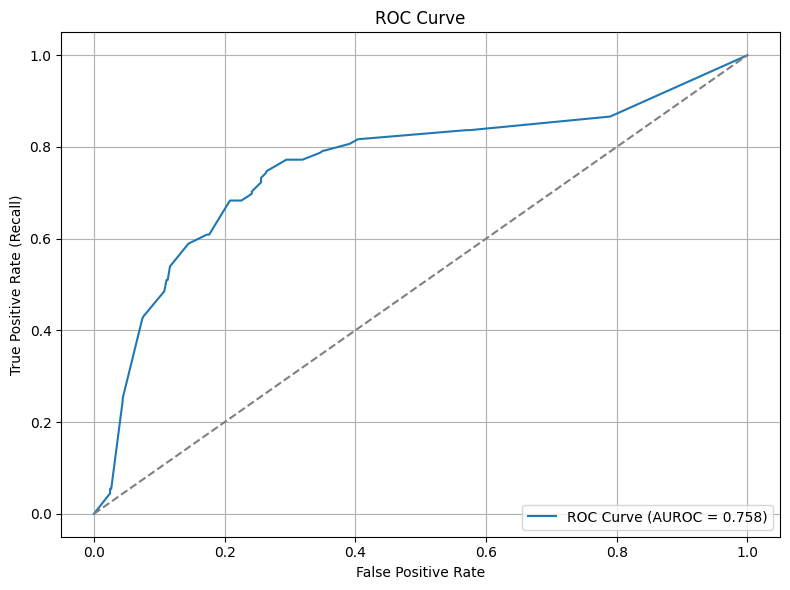

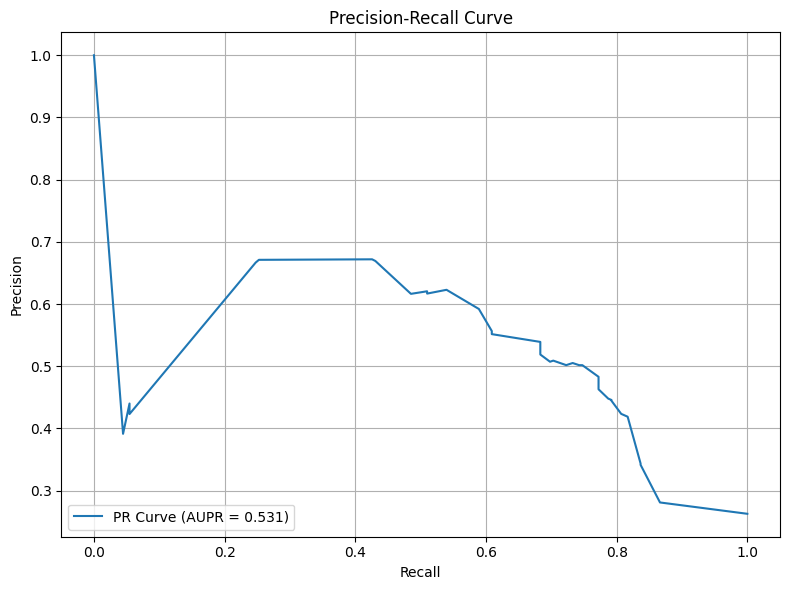

In [ ]:
# Predict class labels
y_pred = dtree.predict(X_test)

# Predict probabilities for ROC and PR curve
y_prob = dtree.predict_proba(X_test)[:, 1]

# Confusion matrix and derived metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Print evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"Accuracy: {accuracy:.3f}")
print(f"Sensitivity / Recall (True Positive Rate): {recall:.3f}")
print(f"Specificity (True Negative Rate): {specificity:.3f}")
print(f"Precision (Positive Predictive Value): {precision:.3f}")
print(f"F1 Score: {f1:.3f}")

# ROC curve and AUROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUROC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

# Precision-Recall curve and AUPR
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall_vals, precision_vals)

plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, label=f"PR Curve (AUPR = {pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid()
plt.tight_layout()
plt.show()



The model achieved an overall accuracy of 78.5% on the test set. However, its sensitivity is only 58.9%, indicating difficulty in correctly identifying good quality wines. In contrast, the specificity is relatively high at 85.5%, showing the model performs well at detecting poor quality wines. The precision for predicting good quality wines is also low at 59.2%, further highlighting the challenge the model faces with this class. Overall, while the model is effective at identifying low quality wines, it struggles to accurately detect high quality ones.

The ROC curve provides a broader view of the model’s ability to distinguish between good and poor quality wines. The curve rises steeply at the beginning, indicating that the model captures a high number of true positives while keeping the false positive rate low in the early stages. However, the curve gradually flattens as the threshold is lowered, suggesting that trying to identify more true positives comes at the expense of misclassifying more poor quality wines as good. The area under the ROC curve (AUROC) is 0.758, reflecting a moderate ability to distinguish between the two classes.

The precision-recall curve gives further insight into the model’s performance on the positive class. The curve shows a sharp initial drop in precision even with a small increase in recall, indicating that while the model is confident in a few correct predictions, its performance quickly declines as it tries to identify more good quality wines. The area under the precision-recall curve (AUPR) is 0.531, which is quite low and confirms the model’s difficulty in handling the positive class. There is a short plateau where both precision and recall remain steady, but this is followed by another drop, suggesting that the model cannot maintain consistent performance as it aims to increase its coverage. Taken together with the ROC analysis and classification metrics, the precision-recall curve highlights the same core issue: the model is much more effective at identifying poor quality wines than it is at recognising the good ones.